## Library Imports


In [1]:
! sudo apt-get install -y python3-dev graphviz libgraphviz-dev pkg-config  graphviz graphviz-dev
! pip uninstall -y sentence-transformers
! pip install pygraphviz torch==2.1.0 transformers==4.25.1 torchvision==0.16.0 torchaudio==2.1.0

import torch
import torch.fx
import accelerate
from transformers.utils.fx import (
    symbolic_trace as symbolic_trace_transformers,
)
import transformers
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# This will reload the imported modules (e.g. analysis) every time you execute the jupyter cells, so that you don't need to restart the notebook after updating the source codes.
%load_ext autoreload
%autoreload 2

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
pkg-config is already the newest version (0.29.2-1ubuntu3).
python3-dev is already the newest version (3.10.6-1~22.04.1).
graphviz is already the newest version (2.42.2-6ubuntu0.1).
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


## Initialization: Understanding FX Graphs

The **symbolic tracer** in PyTorch FX performs “symbolic execution” of Python code, breaking down a function into individual operations.

### **How It Works**
- The tracer records function execution **symbolically**, capturing all operations into an **FX graph**.
- This enables transformation and analysis of the computational graph before execution.

### **Example**
Below is a dummy module with various operators, followed by its corresponding **FX graph node table**.

In [2]:
from analysis import visualize, trace

# Simple module definition
class ModuleA1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.param1 = torch.nn.Parameter(torch.rand(30, 120))
        self.param2 = torch.nn.Parameter(torch.rand(30, 120))
        self.linear = torch.nn.Linear(120, 10)

    def forward(self, x):
        x = torch.mul(x, self.param1)
        x = torch.mul(x, self.param2)
        x = self.linear(x)
        return x.relu()

# Module declaration
module = ModuleA1()

# FX graph.
module_graph = torch.fx.symbolic_trace(module)

# Print the graph as table.
print("Graph Table:")
module_graph.graph.print_tabular()


Graph Table:
opcode         name    target                                                  args           kwargs
-------------  ------  ------------------------------------------------------  -------------  --------
placeholder    x       x                                                       ()             {}
get_attr       param1  param1                                                  ()             {}
call_function  mul     <built-in method mul of type object at 0x7bc135e97aa0>  (x, param1)    {}
get_attr       param2  param2                                                  ()             {}
call_function  mul_1   <built-in method mul of type object at 0x7bc135e97aa0>  (mul, param2)  {}
call_module    linear  linear                                                  (mul_1,)       {}
call_method    relu    relu                                                    (linear,)      {}
output         output  output                                                  (relu,)        {}


A **Graph** is a data structure representing a `GraphModule` method. It contains the following key elements:

- **Inputs (`placeholder` nodes)**:  
  - In FX, method inputs are represented by special `placeholder` nodes.  
  - In this case, we have a single `placeholder` node with a target of `x`, meaning the method has one (non-self) argument named `x`.

- **Operation Nodes**:  
  - The `get_attr`, `call_function`, `call_module`, and `call_method` nodes represent different operations within the method.  
  - A detailed explanation of each can be found in the [`Node`](https://pytorch.org/docs/stable/fx.html#torch.fx.Node) documentation.

- **Output (`output` node)**:  
  - The return value in a [`Graph`](https://pytorch.org/docs/stable/fx.html#torch.fx.Graph) is represented by a special `output` node.

**Refer to the linked documentation** ([Node](https://pytorch.org/docs/stable/fx.html#torch.fx.Node), [Graph](https://pytorch.org/docs/stable/fx.html#torch.fx.Graph)) for a deeper understanding of FX graph structures before proceeding further.


Graph:


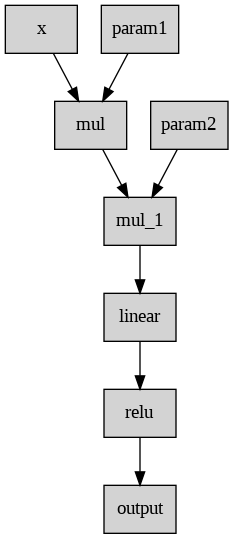

In [3]:
# Graph visualization
print("Graph:")
visualize(module_graph)

## A1: Graph Manipulation [1 point]

You can modify an FX graph by replacing a node's target function.
Complete the `transform` function to modify existing graph nodes:
- Replace all nodes using the [`torch.mul`](https://pytorch.org/docs/stable/generated/torch.mul.html) operator with [`torch.div`](https://pytorch.org/docs/stable/generated/torch.div.html).


In [4]:
def transform(m: torch.nn.Module,
              tracer_class : type = torch.fx.Tracer) -> torch.nn.Module:
    # FX represents its Graph as an ordered list of nodes so we can iterate through them.
    graph : torch.fx.Graph = tracer_class().trace(m)
    for node in graph.nodes:
      if node.target == torch.mul:
        node.target = torch.div

        ## Write the code to replace nodes with mul operator by div operator.
        # pass

    gm = torch.fx.GraphModule(m, graph)
    gm.recompile()
    return gm


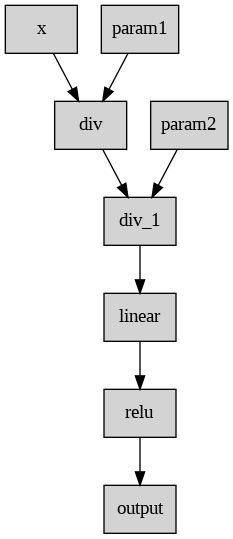

opcode         name    target                                                  args           kwargs
-------------  ------  ------------------------------------------------------  -------------  --------
placeholder    x       x                                                       ()             {}
get_attr       param1  param1                                                  ()             {}
call_function  div     <built-in method div of type object at 0x7e250be97aa0>  (x, param1)    {}
get_attr       param2  param2                                                  ()             {}
call_function  div_1   <built-in method div of type object at 0x7e250be97aa0>  (div, param2)  {}
call_module    linear  linear                                                  (div_1,)       {}
call_method    relu    relu                                                    (linear,)      {}
output         output  output                                                  (relu,)        {}


In [5]:
new_model = transform(module)
new_module_graph = torch.fx.symbolic_trace(new_model)
visualize(new_module_graph)
new_module_graph.graph.print_tabular()

# A2: Graph Analysis I [6 points]

Next, we will analyze a trace graph of one layer of the GPT-3 2.7B model.  
Review the `analysis.py` file and complete the following:

### **1. Set `node.shape` in `NodeProp`**  
   - Assign `node.shape` to the output shape of the node.  
   - Store this value as a **list**, following the format of `torch.Tensor.shape` output.  
   - If the output is **not** a tensor, set `node.shape = None`.  

### **2. Set `node.latency` in `NodeProp`**  
   - Measure the latency of each operator by running it **10 times** and averaging the results.  
   - Use `time.time()` to record execution time and convert the value to **milliseconds**.  
   - For the operators **"placeholder," "output," and "get_attr"**, set `node.latency = 0`.  

{'op': 'placeholder', 'target': 'input_ids', 'args': (), 'kwargs': {}}
{'op': 'call_method', 'target': 'size', 'args': (input_ids,), 'kwargs': {}}
{'op': 'call_function', 'target': <built-in function getitem>, 'args': (size, -1), 'kwargs': {}}
{'op': 'call_method', 'target': 'view', 'args': (input_ids, -1, getitem), 'kwargs': {}}
{'op': 'call_method', 'target': 'size', 'args': (view,), 'kwargs': {}}
{'op': 'call_function', 'target': <built-in function getitem>, 'args': (size_1, 0), 'kwargs': {}}
{'op': 'call_function', 'target': <built-in function getitem>, 'args': (size, -1), 'kwargs': {}}
{'op': 'call_function', 'target': <built-in function add>, 'args': (getitem_2, 0), 'kwargs': {}}
{'op': 'call_function', 'target': <built-in function getattr>, 'args': (view, 'device'), 'kwargs': {}}
{'op': 'call_function', 'target': <built-in method arange of type object at 0x7bc135e97aa0>, 'args': (0, add), 'kwargs': {'dtype': torch.int64, 'device': getattr_1}}
{'op': 'call_method', 'target': 'uns

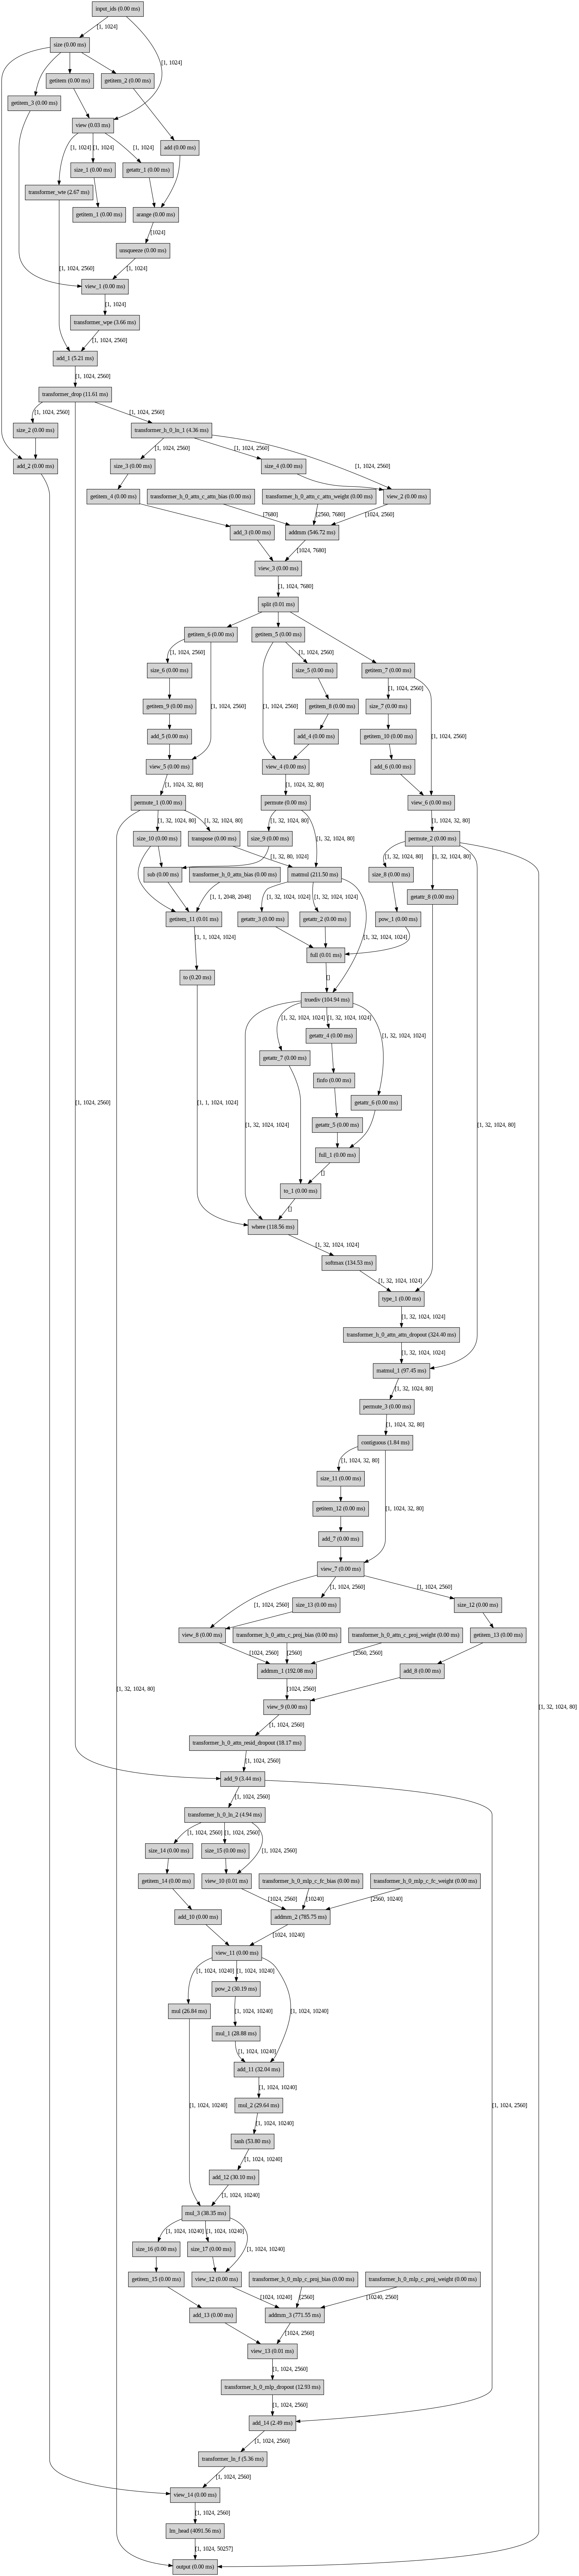

,op,target,args,kwargs,shape,latency
0,placeholder,input_ids,(),{},"[1, 1024]",0.000000
1,call_method,size,"(input_ids,)",{},None,0.000596
2,call_function,<built-in function getitem>,"(size, -1)",{},None,0.000215
3,call_method,view,"(input_ids, -1, getitem)",{},"[1, 1024]",0.032496
4,call_method,size,"(view,)",{},None,0.000358
...,...,...,...,...,...,...
120,call_function,<built-in function add>,"(add_9, transformer_h_0_mlp_dropout)",{},"[1, 1024, 2560]",2.494645
121,call_module,transformer.ln_f,"(add_14,)",{},"[1, 1024, 2560]",5.361128
122,call_method,view,"(transformer_ln_f, add_2)",{},"[1, 1024, 2560]",0.003743
123,call_module,lm_head,"(view_14,)",{},"[1, 1024, 50257]",4091.560864


In [9]:
from model import load_model, input_provider
from analysis import NodeProp, visualize, trace, print_graph, dump_graph

model = load_model()  ## loads the GPT model.
input_ids = input_provider(micro_batch_size=1, sequence_length=1024)  ## Dummy Input

## Graph Generation
graphmodule = trace(model)

print_graph(graphmodule) # Use this for debugging

nodeprop = NodeProp(graphmodule)
graphmodule = nodeprop.propagate(input_ids)

## Graph Visualization
visualize(graphmodule)

# This line creates csv file for submission
dump_graph(graphmodule)

## A.3 Graph Analysis II [1 point]

### **Task**  
Complete the `findHeavyOps` function in `analysis.py` to identify the most time-consuming operations.  

- The function should return the **top 3 nodes** with the highest latency.  
- The result should be a **list of tuples** in the format:  
  ```python
  [(NODE_NAME, LATENCY), ...]


In [12]:
from analysis import findHeavyOps

print(findHeavyOps(graphmodule))

[('lm_head', 4091.5608644485474), ('addmm_2', 785.748553276062), ('addmm_3', 771.5468883514404)]
